In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython import display
import pickle
import ast
import math 
import traceback

import seaborn as sns

2023-11-13 13:15:46.356761: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%matplotlib inline
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
class DatasetWrapper:
    def __init__(self, dataset, split):
        self.dataset = dataset
        self.split = split

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        data, target = self.dataset[index]


        return {"images":data,
                'labels':target,
                'meta':{'indices':index}}


with open('mushroom_train.pkl', 'rb') as f:
    data = pickle.load(f)
    y = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    X = np.array([data[i]["images"].numpy() for i in range(len(data))])

with open('mushroom_test.pkl', 'rb') as f:
    data = pickle.load(f)
    ytest = np.array([data[i]["labels"].numpy() for i in range(len(data))])
    Xtest = np.array([data[i]["images"].numpy() for i in range(len(data))])

## Specify learning algorithms

In [4]:
import math


def sigmoid(x):
    y = 1 / (1 + np.exp(-x))
    return y


def forward_logloss(X, theta):
    y = np.dot(X, theta.T)
    y = sigmoid(y)
    return y


def backward_logloss(xx, yy, p):
    grad = (p - yy) * xx
    return grad


def cross_entropy(p, y, epsilon=1e-15):
    l = -np.mean(
        y * np.log(np.maximum(p, epsilon))
        + (1 - y) * np.log(np.maximum(1 - p, epsilon))
    )
    return l


def accuracy_prob(p, y):
    y = y.flatten()
    p = p.flatten()
    sy = 2 * y - 1
    sp = np.sign(p - 1 / 2)
    a = (np.sign(sy * sp) + 1) / 2
    return np.mean(a)


def ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
    else:
        y = math.exp(u)
    return y


def log_ratio(u):
    if u <= 10:
        y = ((1 + math.exp(u)) ** 2) * math.log(1 + math.exp(-u))
        log_y = np.log(y)
    else:
        log_y = u
    return log_y


def update(theta, grad, eta=0.01, lam=2):
    newtheta = theta - eta * (grad + 0.5 * lam * theta)
    return newtheta

In [5]:
loss = cross_entropy
forward = forward_logloss
backward = backward_logloss
accuracy = accuracy_prob

def train_model(
    X,
    y,
    Xtest,
    ytest,
    mode="rand",
    eta=0.01,
    lam=0,
    # Used in all the Polyak methods
    kappa=1,
    kappa0=0.1,
    # Used in Polyak and Polyak-bec
    polyakexp=1 / 2,
    # multiplier to control sampling probability
    omega=1,
    # Added to enable non-adaptive stepsize experiments with pz != 1/2
    pz0 = 1/2,
    # For bec-minx1
    alpha = 1,
    x0 = 1,
    # debug
    verbose=True,
    epsilon = 1e-15,
):
    theta = np.zeros(X.shape[1])
    stheta = theta

    n_iterations = X.shape[0]  # Number of iterations
    #thetas = np.zeros((n_iterations, X.shape[1]))
    
    if verbose:
        print(f"Training with algorithm {mode}: {n_iterations} iterations with d={X.shape[1]}")
        
    losses = np.zeros(n_iterations)
    losses_reg = np.zeros(n_iterations)
    losses_test = np.zeros(n_iterations)
    losses_test_reg = np.zeros(n_iterations)
    accuracies = np.zeros(n_iterations)
    accuracies_test = np.zeros(n_iterations)
    labeled = np.zeros(n_iterations)
    #Delta = np.zeros(n_iterations)
    #sDelta = np.zeros(n_iterations)
    probs = np.zeros(n_iterations)
    #samples = []

    # for i in range(npoints):
    for i in range(n_iterations):
        xx = X[i, :]
        yy = y[i]

        p = 0
        q = 0
        pz = 1 / 2
        grad = 0

        if mode == "random":
            pz = pz0
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
        elif mode == "polyak_absloss":
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = omega / (1 + np.exp(u))
            pz = np.clip(pz, a_min=0, a_max=1)
            grad = zeta * grad / pz
        elif mode == "polyak_exponent": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            #zeta = kappa * (ratio(u) / (np.linalg.norm(xx) ** 2))
            zeta_log = math.log(kappa) + log_ratio(u) - math.log(np.linalg.norm(xx) ** 2)
            #zeta = math.exp(zeta_log)
            #zeta = min(zeta, kappa0)
            zeta = math.exp(min(zeta_log, math.log(kappa0)))
            pz = zeta ** polyakexp
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "polyak_exponent_old": 
            p = forward(xx, theta)
            grad = backward(xx, yy, p)
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            pz = zeta ** polyakexp
            grad = (zeta ** (1 - polyakexp)) * grad
        elif mode == "uncertainty":
            w = theta
            p = forward(xx, theta)
            q = forward(xx, w)
            pz = p * (1 - q) + (1 - p) * q
            
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            
            grad = backward(xx, yy, p)
        elif mode == "absloss":
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = 1 - np.exp(-bec)
            pz = omega * pz
            pz = np.clip(pz, a_min=epsilon, a_max=1-epsilon)
            grad = backward(xx, yy, p)
        elif mode == "minx1":  
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            pz = np.min([(bec / x0) ** alpha, 1])
            grad = backward(xx, yy, p)
        elif mode == "polyak-minx1":
            # Binary cross-entropy loss with Polyak adaptive step size
            p = forward(xx, theta)
            bec = cross_entropy(p, yy)
            grad = backward(xx, yy, p)
            
            # Compute pz as in bec-minx1 mode
            pz = np.min([(bec / x0) ** alpha, 1])

            # Compute u and zeta as in polyak-bec mode
            u = (2 * yy - 1) * np.dot(xx, theta)
            zeta = kappa * ratio(u) / (np.linalg.norm(xx) ** 2)
            zeta = min(zeta, kappa0)
            
            # Compute the gradient of the binary cross-entropy loss with respect to theta
            dL_dpz = -(y / pz - (1 - y) / (1 - pz))
            dL_dbec = 0 if (bec / x0) > 1 else alpha * ((bec / x0) ** (alpha - 1)) / x0

            # Apply the Polyak adaptive step size to the gradient
            scaling_factor = zeta ** (1 - polyakexp)
            grad = scaling_factor * grad

        # sampling
        pz = np.clip(pz, epsilon, 1-epsilon)
        z = np.random.binomial(1, pz)
        losses[i] = loss(p, yy)
        losses_reg[i] = losses[i] + lam * np.linalg.norm(theta)
        
        #stheta = (1 - 1 / (i + 1)) * stheta + (1 / (i + 1)) * theta
        accuracies[i] = accuracy(p, yy)

        labeled[i] = z
        probs[i] = pz
        # parameter update
        if z > 0:
            theta = update(theta, grad, eta=eta, lam=lam)
            #samples.append(i)

        """
        theta_norm = theta
        if np.linalg.norm(theta)>0:
          theta_norm = theta / np.linalg.norm(theta)
        Delta.append(np.linalg.norm(theta_norm-theta_star))

        stheta_norm = stheta
        if np.linalg.norm(stheta)>0:
          stheta_norm = stheta / np.linalg.norm(stheta)
        sDelta.append(np.linalg.norm(stheta_norm-theta_star))
        """

        p = forward(Xtest, theta)
        losses_test[i] = loss(p, ytest)
        losses_test_reg[i] = losses_test[i] + lam * np.linalg.norm(theta)
        accuracies_test[i] = accuracy(p, ytest)
        
        """
        p = forward(Xtest, stheta)
        ltest = loss(p, ytest) + lam * np.linalg.norm(stheta)
        slosses_test.append(ltest)
        """
        
        #p = forward(Xtest, theta)

        """
        p = forward(Xtest, stheta)
        a = accuracy(p, ytest)
        saccuracies_test.append(a)
        """

        if verbose and i % 200 == 0:
            print(f"loss: {losses_test[i]}, train loss: {losses[i]}, ||theta||_1: {np.sum(np.abs(theta))}")

    return {
        "losses": losses.tolist(),
        "losses_reg": losses_reg.tolist(),
        "losses_test": losses_test.tolist(),
        "losses_test_reg": losses_test_reg.tolist(),
        "labeled": labeled.tolist(),
        "theta": theta.tolist(),
        #"stheta": stheta,
        "probs": probs.tolist(),
        "accuracies": accuracies.tolist(),
        "accuracies_test": accuracies_test.tolist(),
        #"samples": samples.tolist(),
        #"thetas": thetas.tolist(),
    }

## Use best hyperparams to construct plot
We have stored results from our hyperparameter tuning run. Here we load the results file, and will use the best hyperparameters per method.

In [6]:
hyperparam_results = pd.read_csv("hyperparams_train_loss_zero_init_noreg_target050_eta300.csv", delimiter="\t", header=None)
hyperparam_results.columns = ["algorithm", "loss", "hyperparams"]

In [7]:
# Calculate best hyperparameters per method
min_losses = pd.DataFrame(hyperparam_results.groupby("algorithm").loss.min()).reset_index()
best_hyperparams = min_losses.merge(hyperparam_results, on=["algorithm", "loss"], how="left")

hyperparam_per_algo = {
    algorithm: ast.literal_eval(hyperparam) for 
    algorithm, hyperparam in 
    zip(best_hyperparams["algorithm"], best_hyperparams["hyperparams"])
}

In [10]:
hyperparam_per_algo["absloss"] = {"eta": 300}
hyperparam_per_algo["random"] = {"eta": 300}
hyperparam_per_algo["uncertainty"] = {"eta": 300}

In [11]:
hyperparam_per_algo

{'polyak_absloss': {'kappa': 35.52674391886635,
  'kappa0': 0.998009193683614,
  'eta': 300,
  'omega': 0.5588345498272365},
 'polyak_exponent': {'kappa': 17.108470703379435,
  'kappa0': 0.4983247553412293,
  'eta': 300,
  'polyakexp': 0.9951814804061615},
 'absloss': {'eta': 300},
 'random': {'eta': 300},
 'uncertainty': {'eta': 300}}

# Plot 0: train loss of rand vs absloss (first run for absloss, then run for rand for matching pz)

- mean train loss curve
- mean test loss curve
- accuracy

In [12]:
absloss_params = hyperparam_per_algo["absloss"]

results_absloss = train_model(
    X, y, Xtest, ytest, mode="absloss", **absloss_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6914802275902776, train loss: 0.6931471805599453, ||theta||_1: 174.03449382728803
loss: 0.5787958100581604, train loss: 0.5192475429889283, ||theta||_1: 15700.633767533913
loss: 0.5121788734169735, train loss: 0.003115382839163676, ||theta||_1: 26238.842628712948
loss: 0.4520339351418264, train loss: 0.39450622463891905, ||theta||_1: 36249.6667566108
loss: 0.4126092537065028, train loss: 0.0032514299108452214, ||theta||_1: 44001.99388241765
loss: 0.3667952966772604, train loss: 0.5247763661850309, ||theta||_1: 52048.67188063679
loss: 0.3368884244063642, train loss: 0.6820135622017767, ||theta||_1: 58470.139396007486
loss: 0.31277565886344466, train loss: 0.5464578203647059, ||theta||_1: 64432.02494592998
loss: 0.2900535989746029, train loss: 0.31203539130101515, ||theta||_1: 69731.25259443485
loss: 0.26626141046095264, train loss: 0.002960748987383962, ||theta||_1: 75079.12338564727
loss: 0.25054671140241414, train lo

In [13]:
absloss_mean_sampling_prob = np.mean(results_absloss["probs"])

In [14]:
absloss_mean_sampling_prob

0.15332862165740882

In [15]:
rand_params = hyperparam_per_algo["random"]

results_rand = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(rand_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6590188958957929, train loss: 0.6931471810759863, ||theta||_1: 4916.161716490308
loss: 0.6198098673721711, train loss: 0.692391520400839, ||theta||_1: 10475.789328998622
loss: 0.5923689168273658, train loss: 0.6899136410747473, ||theta||_1: 13966.92948332644
loss: 0.5551229280229099, train loss: 0.004003348392735067, ||theta||_1: 18783.65491419173
loss: 0.5216703552543678, train loss: 0.5005702237903106, ||theta||_1: 23363.123988381034
loss: 0.4954773001583758, train loss: 0.6819913212521167, ||theta||_1: 28054.60838835414
loss: 0.47688446587835487, train loss: 0.39457849805386036, ||theta||_1: 31059.27354809716
loss: 0.45280647940789304, train loss: 0.002793930148590049, ||theta||_1: 35442.84267001296
loss: 0.4328738718829454, train loss: 0.003356738920065907, ||theta||_1: 38847.56118474294
loss: 0.41680035502770035, train loss: 7.8436995186476

In [16]:
results_rand_absloss_params = train_model(
    X, y, Xtest, ytest, mode="random", verbose=True, **(absloss_params | {"pz0": absloss_mean_sampling_prob})
)

Training with algorithm random: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.6518364597397894, train loss: 0.6931471808666375, ||theta||_1: 5401.174219097073
loss: 0.610975770679567, train loss: 0.5928963011852034, ||theta||_1: 10962.350168074783
loss: 0.579219527759312, train loss: 0.5705768745484117, ||theta||_1: 15032.062720151294
loss: 0.5529002265061564, train loss: 0.6909647111834516, ||theta||_1: 19050.38980340205
loss: 0.5290120826801659, train loss: 0.5441645958911505, ||theta||_1: 23230.76600136024
loss: 0.5068264825114774, train loss: 0.6905891072587251, ||theta||_1: 27124.12898820156
loss: 0.4817700535373187, train loss: 0.5125584104810185, ||theta||_1: 31007.812247486076
loss: 0.4632571446651932, train loss: 0.5816684463736183, ||theta||_1: 34270.419184666694
loss: 0.4464414694245543, train loss: 0.014769516539951951, ||theta||_1: 37016.5821311386
loss: 0.43333205960439924, train loss: 0.5219110310840939, ||

In [17]:
results_absloss_rand_params = train_model(
    X, y, Xtest, ytest, mode="absloss", verbose=True, **rand_params
)

Training with algorithm absloss: 6499 iterations with d=6499
loss: 0.6914802275902776, train loss: 0.6931471805599453, ||theta||_1: 174.03449382728803
loss: 0.5923897154738307, train loss: 0.5972668149915447, ||theta||_1: 13845.991933936528
loss: 0.5091521453281748, train loss: 0.5353121767688795, ||theta||_1: 26971.947411802666
loss: 0.45420237437742994, train loss: 0.4575877984323259, ||theta||_1: 36899.587527737836
loss: 0.40786437425379246, train loss: 0.005463758497470074, ||theta||_1: 45552.929169050454
loss: 0.3625718100512866, train loss: 0.610510167095686, ||theta||_1: 53695.920063983394
loss: 0.33214665808748073, train loss: 0.0032783421149974244, ||theta||_1: 60246.89947797936
loss: 0.30814953070256995, train loss: 0.3206804088704936, ||theta||_1: 65569.96095415995
loss: 0.2850754319988359, train loss: 0.49578909294993934, ||theta||_1: 70831.50494249696
loss: 0.2703285337858052, train loss: 0.4614560167619109, ||theta||_1: 73892.01611604229
loss: 0.2528003483264272, train lo

In [18]:
def results_to_df(results):
    dfs = []
    for k, v in results.items():
        df = pd.DataFrame(
            {
                "train_loss": v["losses"],
                "train_loss_reg": v["losses_reg"],
                "test_loss": v["losses_test"],
                "test_loss_reg": v["losses_test_reg"],
                "iteration": range(1, len(v["losses"]) + 1),
                "labeled": v["labeled"],
                "probs": v["probs"],
                "train_accuracy": v["accuracies"],
                "test_accuracy": v["accuracies_test"],
            }
        )
        df["method"] = k
        df["mean_train_loss"] = np.cumsum(df.train_loss) / df.iteration
        df["mean_test_loss"] = np.cumsum(df.test_loss) / df.iteration
        df["mean_test_accuracy"] = np.cumsum(df.test_accuracy) / df.iteration
        df["mean_train_accuracy"] = np.cumsum(df.train_accuracy) / df.iteration
        df["cost"] = np.cumsum(df.labeled)
        dfs += [df]   
    
    return pd.concat(dfs, axis=0)

results_df = results_to_df(
    {
        "absloss": results_absloss,
        "random": results_rand,
        "random_with_absloss_params": results_rand_absloss_params,
        "absloss_with_random_params": results_absloss_rand_params,
    }
)

(0.0, 1000.0)

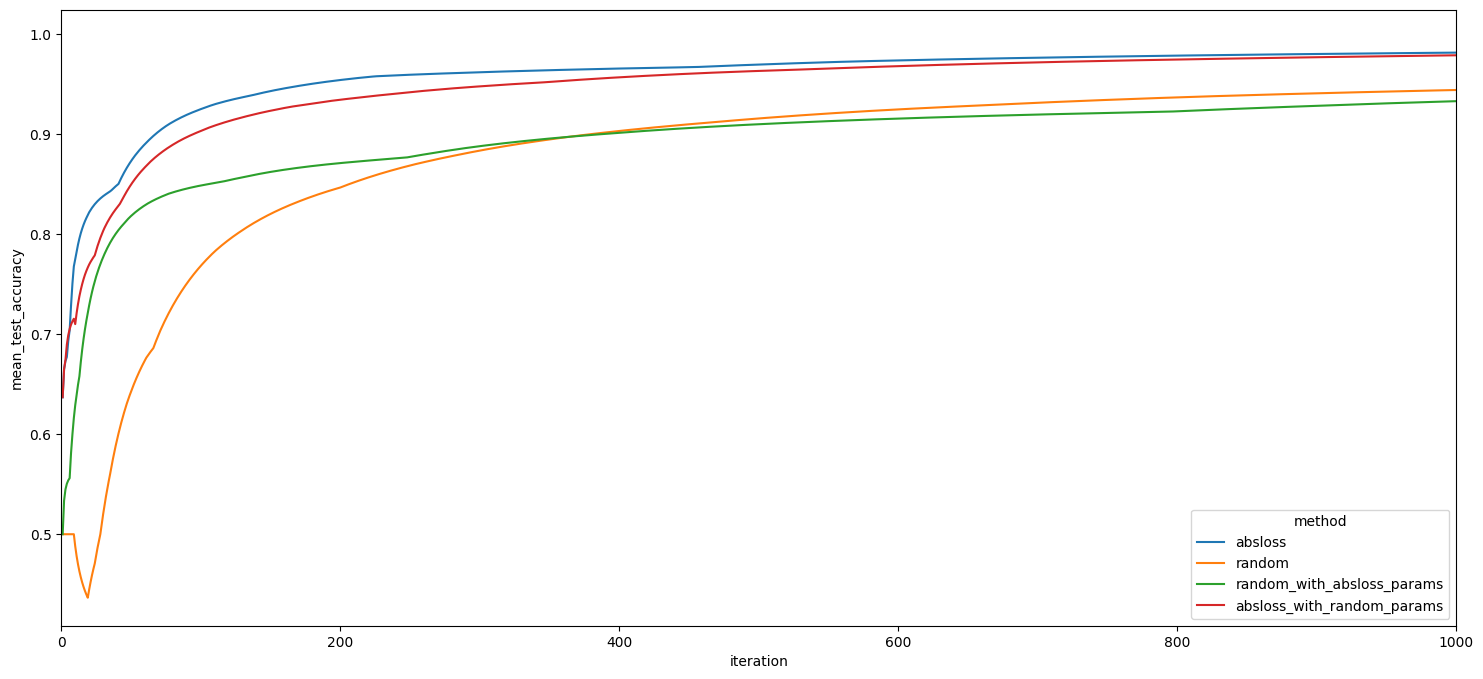

In [19]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df,#results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

(0.0, 1000.0)

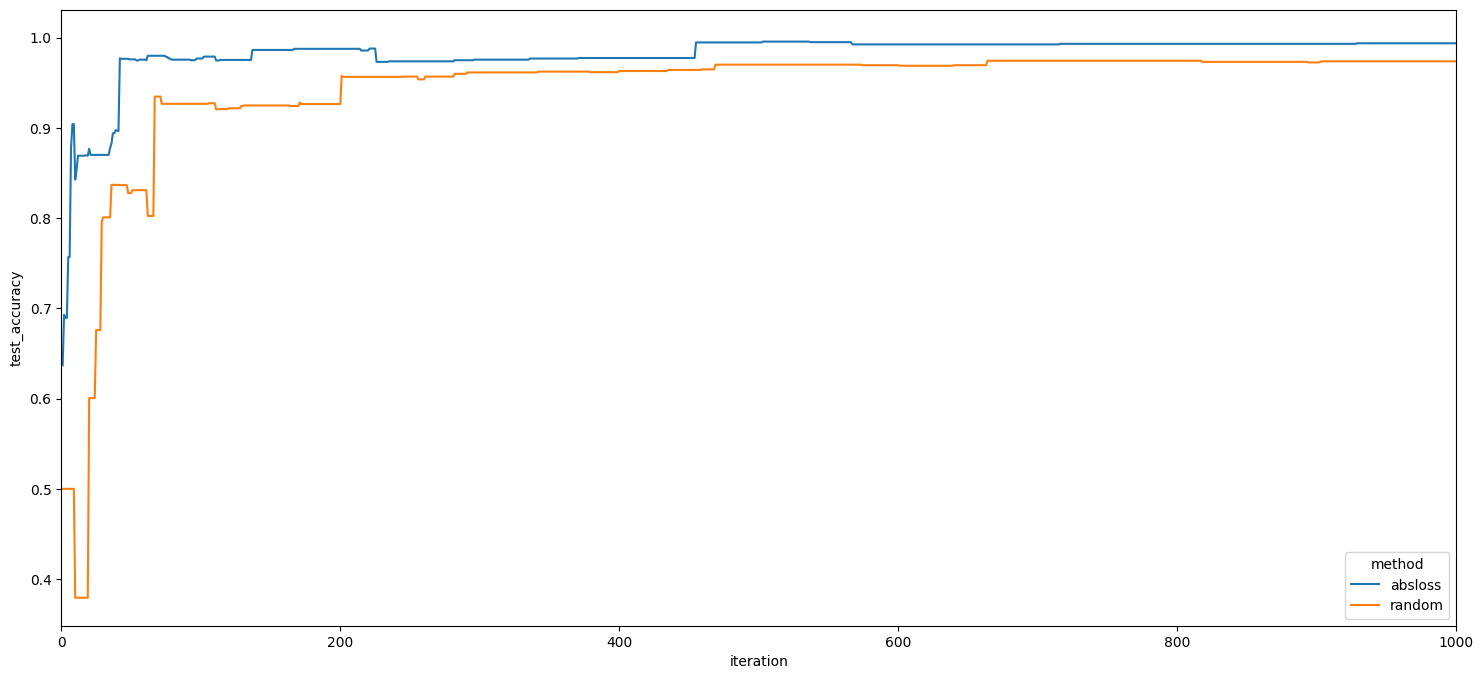

In [20]:
plt.figure(figsize=(18,8))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="test_accuracy",
    hue="method"
)

ax.set_xlim((0, 1000))

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

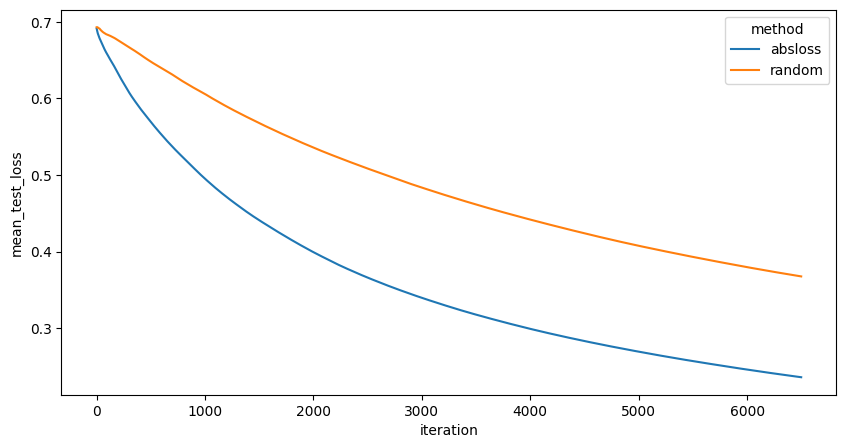

In [21]:
plt.figure(figsize=(10,5))

sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

Text(0, 0.5, 'average cross entropy loss')

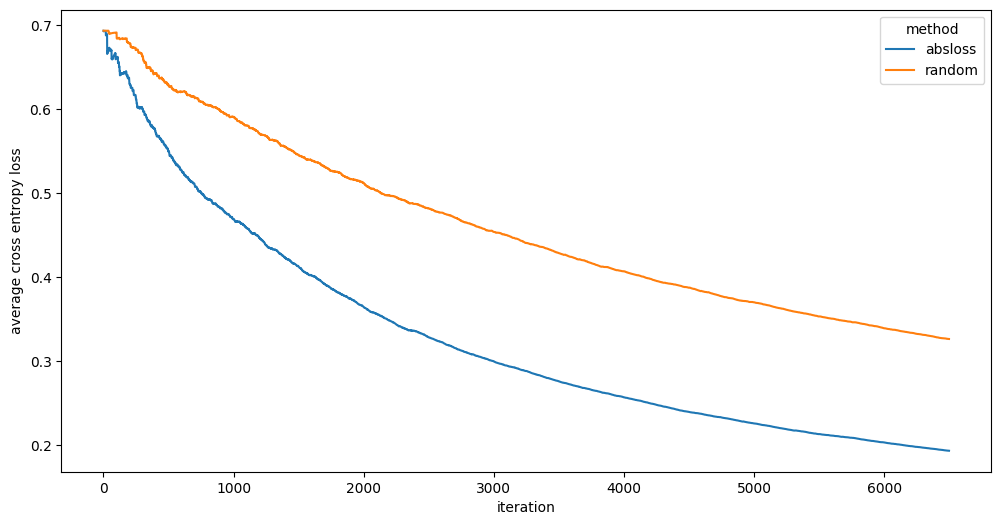

In [22]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

#plt.xscale('log')
#plt.yscale('log')

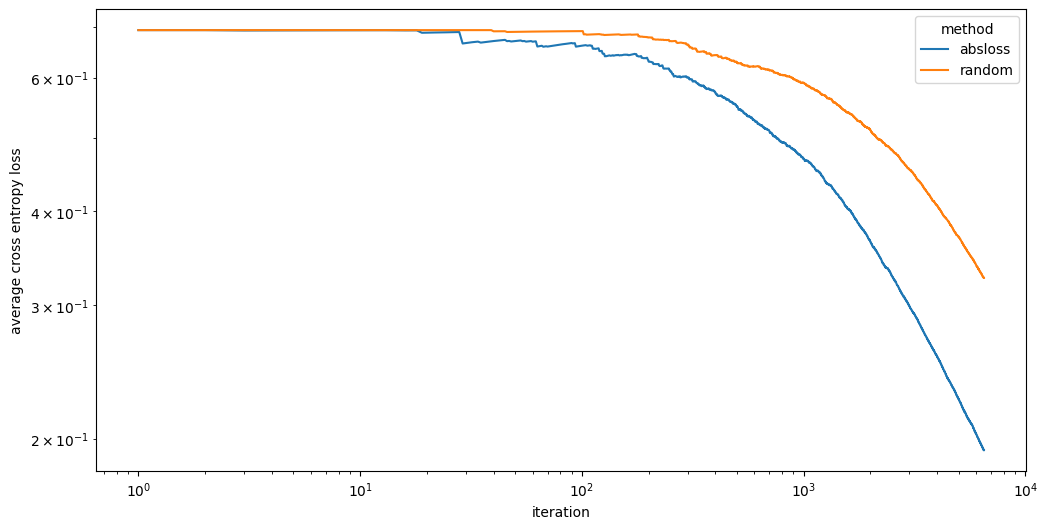

In [23]:
plt.figure(figsize=(12,6))

ax = sns.lineplot(
    data=results_df[results_df.method.isin(["absloss", "random"])],
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)

ax.set_ylabel("average cross entropy loss")
#ax.set_xlim((0, 6499))

plt.xscale('log')
plt.yscale('log')

# Plot 1: train loss of rand vs Polyak exponent 
First run for various Polyak exponent values, and the run for rand for matching pz

- mean train loss curve
- mean test loss curve
- accuracy

For a single instance, polyak exponent method does:

pz = zeta ** polyakexponent

We aim to control the mean of pz across the dataset. 
we can find approximate solutions by taking zeta to be constant.

mean_pz = c ** polyakexponent

We don't know what c is because it depends on kappa, kappa0, 
and the losses in complex ways. However,  Then we can run the training loop
with polyakexp = 1 and take the empirical mean of the pz values to find our estimate for c.

Now we can find estimates of the polyakexp values that will lead to any desired mean_pz a using:

a = c ** polyakexp
log(a) = log(c ** ployakexp)
log(a) = ployakexp * log(c)
polyakexp = log(a) / log(c)

In practice, c is not a constant, but we instead have an instance-specific zeta.
As a result, it is likely that when we use this to derive this equation that gives us a value of polyakexp
for a desired sampling probability a, that the empirical mean sampling probability somewhat deviates that.

This is OK, since we're not looking to control pz precisely. Rather, we are looking to verify that polyak exponent
is more efficient than random sampling even in scenarios where we sample. We are simply looking to cover a wide range
of sampling probabilities.

To achieve a fair comparison against random sampling, we will calculate the empirical pz of the polyak exponent runs under a
and then run a random sampling under the same probability.

In [24]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyakexp_1_results = train_model(
    X, y, Xtest, ytest, mode="polyak_exponent", **(polyak_exponent_params | {"polyakexp": 1})
)

c = np.mean(polyakexp_1_results["probs"])

Training with algorithm polyak_exponent: 6499 iterations with d=6499
loss: 0.6914802275902776, train loss: 0.6931471805599453, ||theta||_1: 174.03449382728803
loss: 0.5960119497004117, train loss: 0.6929099590064162, ||theta||_1: 13349.85241998396
loss: 0.5064471417423284, train loss: 0.6128464667027428, ||theta||_1: 27010.81398793462
loss: 0.4483149889083347, train loss: 0.005654873599563975, ||theta||_1: 37933.78746075785
loss: 0.39020154327216106, train loss: 0.46893416184945735, ||theta||_1: 48063.68297134417
loss: 0.3405027936776594, train loss: 0.47928238842002896, ||theta||_1: 56644.69939024157
loss: 0.30505955322217415, train loss: 0.5879946357654036, ||theta||_1: 64275.54567310032
loss: 0.27740558667255033, train loss: 0.007566732488069723, ||theta||_1: 70880.5337437952
loss: 0.25552637867416966, train loss: 3.363947668458198e-06, ||theta||_1: 76431.85689241716
loss: 0.2315673328665097, train loss: 0.0033589251504338893, ||theta||_1: 82058.03768716402
loss: 0.20670551155728148

In [25]:
# We're aiming to achieve sampling probabilities <0.1, 0.2, ..., 1.0>
#target_pzs = [0.1 * i for i in range(1, 11)]
target_pzs = [0.01, 0.1, 0.25, 0.5]
polyak_exps = [math.log(a) / math.log(c) for a in target_pzs]
polyak_exps

[6.6118426385456495, 3.3059213192728247, 1.990362960812323, 0.9951814804061615]

In [26]:
polyak_exponent_params = hyperparam_per_algo["polyak_exponent"]

polyak_exponent_results = {
    f"polyak_exponent_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="polyak_exponent", verbose=False, **(polyak_exponent_params | {"polyakexp": polyak_exp})
    )
    for polyak_exp in polyak_exps
}

In practice, c is not a constant, but we instead have an instance-specific zeta that depends on kappa, kappa0, and the losses in complex ways.
As a result, it is likely that the empirical mean sampling probabilities somewhat deviate from our targets target_pzs.

We now calculate the empirical pzs of these polyak exponent runs.

In [27]:
empirical_pzs = []
for key in polyak_exponent_results.keys():
    empirical_pzs += [np.mean(polyak_exponent_results[key]["probs"])]

In [28]:
empirical_pzs

[0.010000000000000014,
 0.10000000000000005,
 0.25000000000000006,
 0.5000000000000001]

In [29]:
rand_params = hyperparam_per_algo["random"]

rand_results = {
    f"random_{polyak_exp:.1f}": train_model(
        X, y, Xtest, ytest, mode="random", verbose=False, **(rand_params | {"pz0": empirical_pz})
    )
    for polyak_exp, empirical_pz in zip(polyak_exps, empirical_pzs)
}

In [30]:
plot1_df = results_to_df((rand_results | polyak_exponent_results))
plot1_df[['method', 'polyak_exp']] = plot1_df['method'].str.rsplit('_', n=1, expand=True)

In [31]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).train_loss.mean()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.156052
                 2.0         0.25     0.209738
                 3.3         0.10     0.268991
                 6.6         0.01     0.486937
random           1.0         0.50     0.157907
                 2.0         0.25     0.255549
                 3.3         0.10     0.415537
                 6.6         0.01     0.645264
Name: train_loss, dtype: float64

In [32]:
plot1_df.groupby(["method", "polyak_exp", "probs"]).mean_train_loss.min()

method           polyak_exp  probs
polyak_exponent  1.0         0.50     0.156052
                 2.0         0.25     0.209727
                 3.3         0.10     0.268991
                 6.6         0.01     0.486909
random           1.0         0.50     0.157907
                 2.0         0.25     0.255549
                 3.3         0.10     0.415537
                 6.6         0.01     0.645208
Name: mean_train_loss, dtype: float64

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


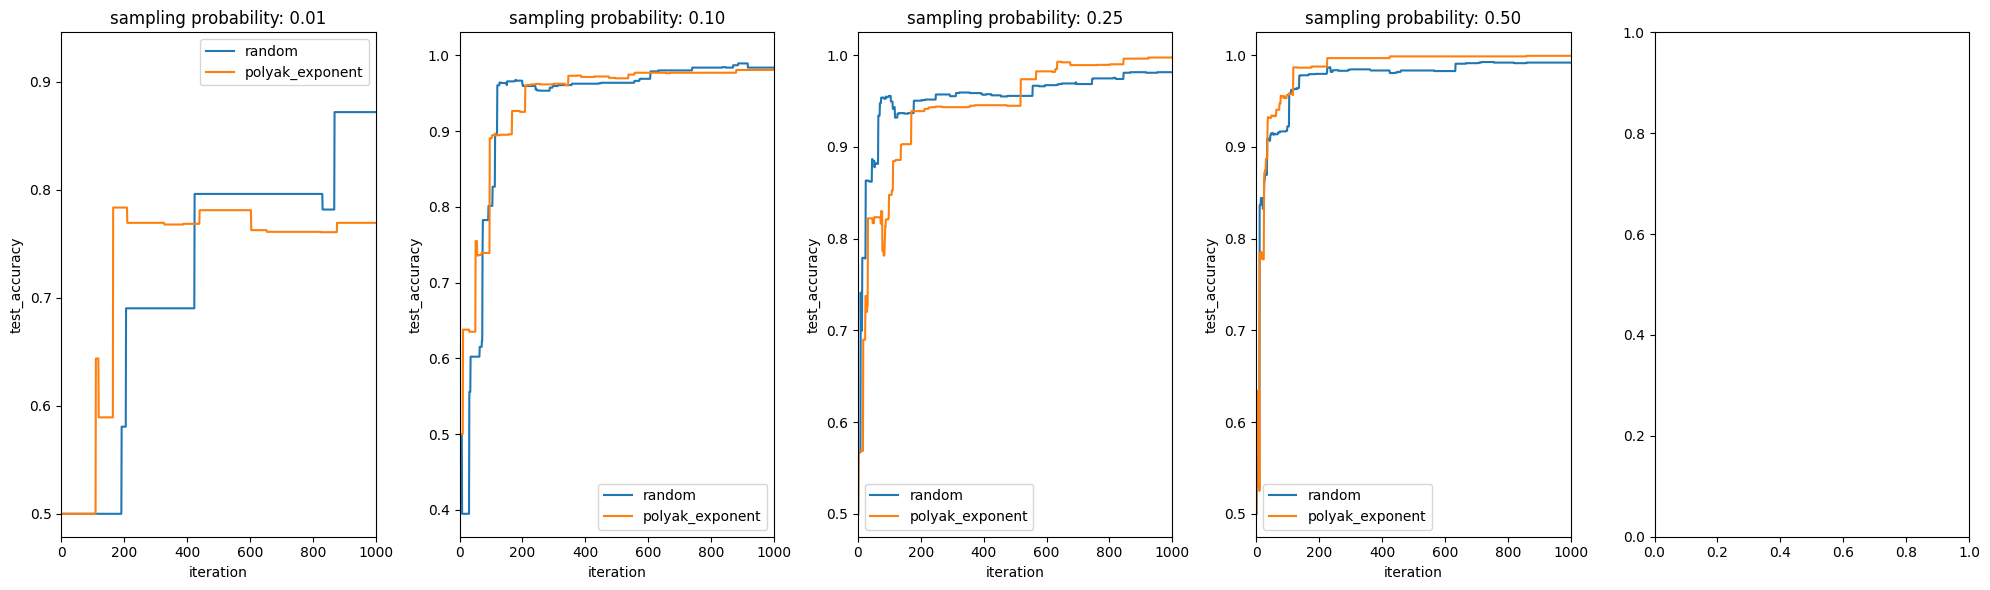

In [33]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]#[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_accuracy", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    ax.set_xlim((0, 1000))
    
    i+=1
f.tight_layout()

Polyak exp value 6.6 has rows (12998, 16)
Polyak exp value 3.3 has rows (12998, 16)
Polyak exp value 2.0 has rows (12998, 16)
Polyak exp value 1.0 has rows (12998, 16)


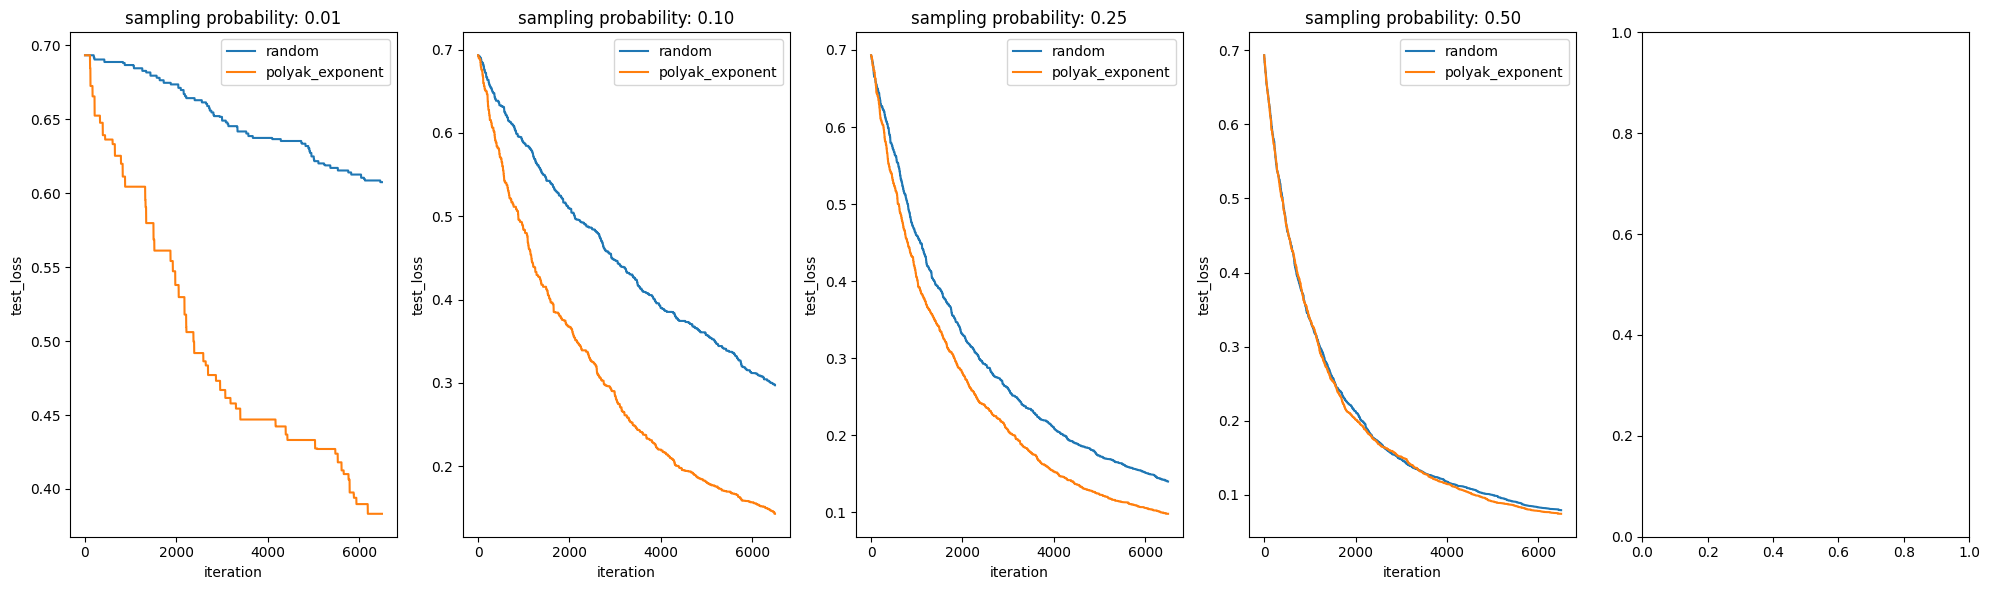

In [34]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    #ax.set_ylim((0.63, 0.7))
    
    i+=1
f.tight_layout()

In [35]:
plot1_df["method"] = [method if method != "polyak_exponent" else "polyak_power_function" for method in plot1_df.method]

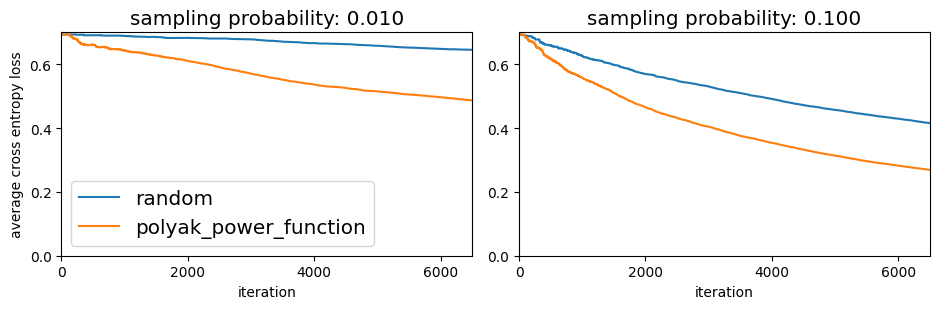

In [36]:
f, axs = plt.subplots(1, 2, figsize=(9.5, 3.2))
i = 0
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

for polyak_exp, pz in zip(polyak_exps[:2], empirical_pzs[:2]):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.3f}")
    ax.legend()
    ax.set_ylim((0.00, 0.7))
    ax.set_xlim((0, 6499))
    #ax.set_xlim((0, 6000))
    
    i+=1
    
axs[0].set_ylabel("average cross entropy loss")
axs[1].set_ylabel("")

axs[1].get_legend().remove()

f.tight_layout()

plt.savefig("figure_2.pdf", format="pdf", bbox_inches="tight")

0.010000000000000014
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000005
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


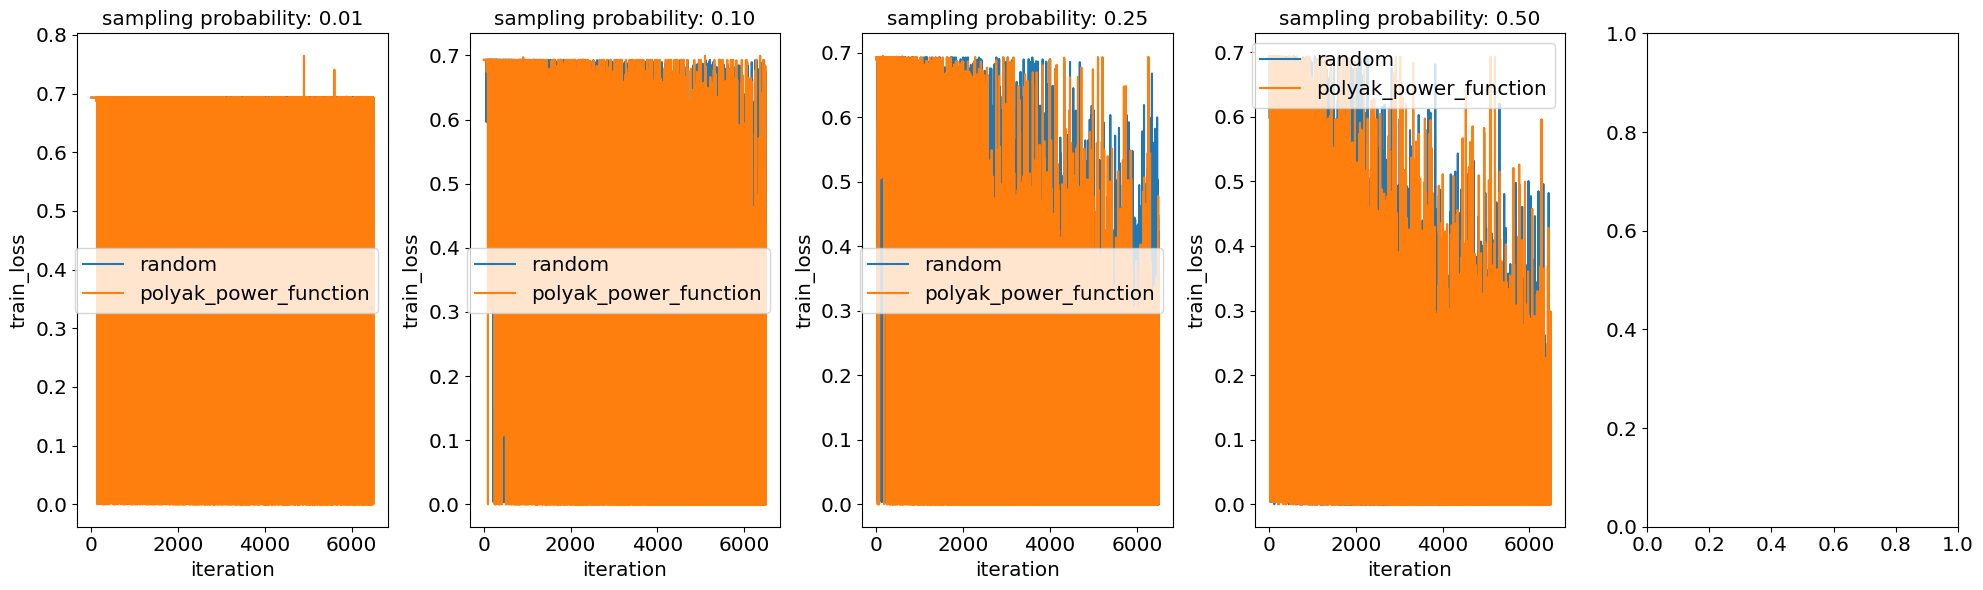

In [37]:
f, axs = plt.subplots(1, 5, figsize=(20, 6))
i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="train_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    
    i+=1
f.tight_layout()

0.010000000000000014
Polyak exp value 6.6 has rows (12998, 16)
0.10000000000000005
Polyak exp value 3.3 has rows (12998, 16)
0.25000000000000006
Polyak exp value 2.0 has rows (12998, 16)
0.5000000000000001
Polyak exp value 1.0 has rows (12998, 16)


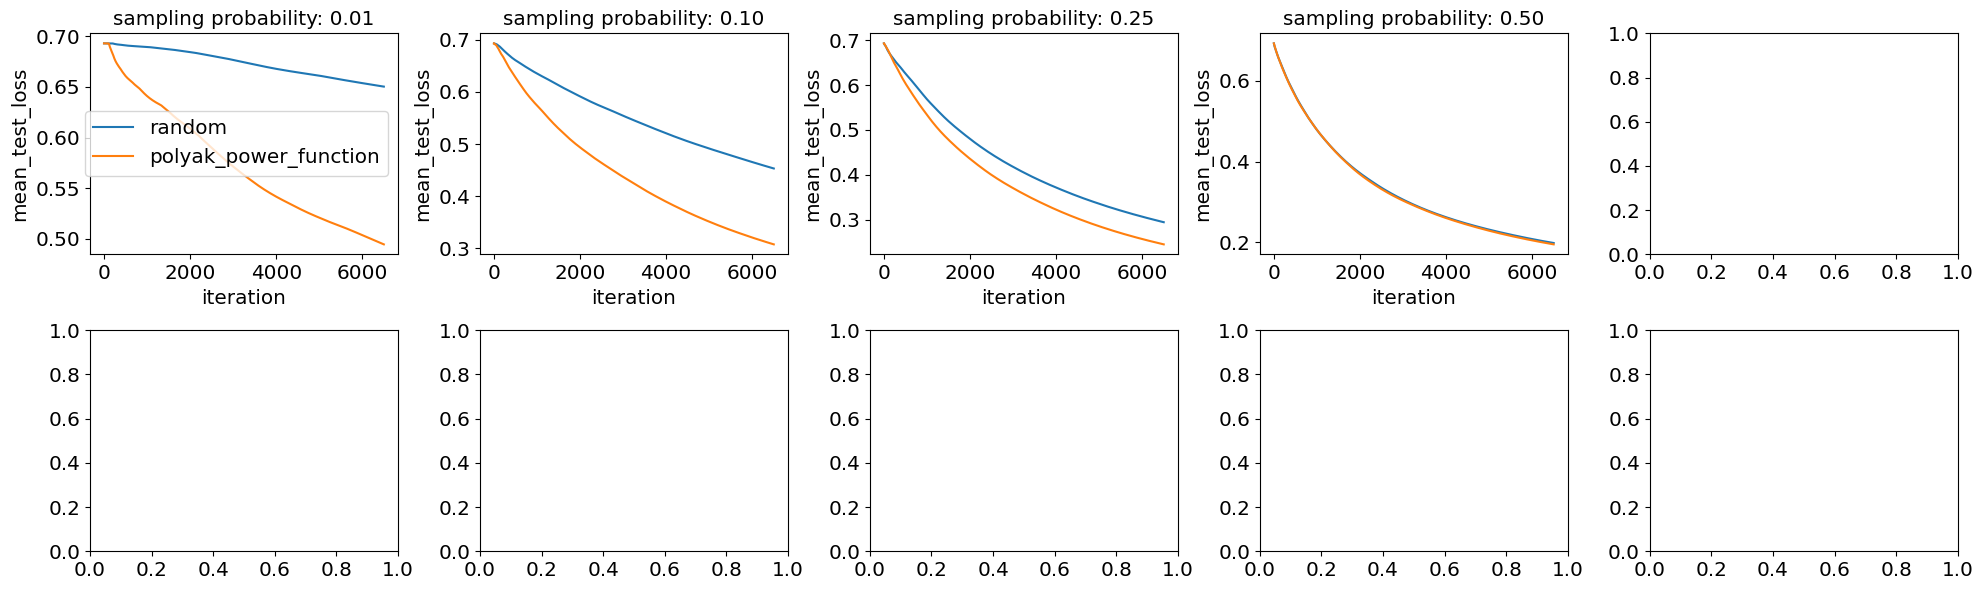

In [38]:
f, axs = plt.subplots(2, 5, figsize=(20, 6))
handles, labels = [], []

i = 0
for polyak_exp, pz in zip(polyak_exps, empirical_pzs):
    # Specify the current axis to plot on
    ax = axs[i // 5][i % 5]
    
    polyak_exp_key = str(round(polyak_exp, 1))
    print(pz)
    print(f"Polyak exp value {polyak_exp_key} has rows {plot1_df[plot1_df.polyak_exp == polyak_exp_key].shape}")
    # Create the line plot on the current axis
    sns.lineplot(
        data=plot1_df[plot1_df.polyak_exp == polyak_exp_key], 
        x="iteration", 
        y="mean_test_loss", 
        hue="method",
        ax=ax
    )
    
    ax.set_title(f"sampling probability: {pz:.2f}")
    ax.legend()
    #ax.set_xlim((0, 6000))
    if i == 0:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    else:
        ax.get_legend().remove()
    
    i+=1
f.tight_layout()

# Plot 2: Polyak absloss vs absloss
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability

- mean train loss curve
- mean test loss curve
- accuracy

In [39]:
hyperparam_per_algo["polyak_absloss"]

{'kappa': 35.52674391886635,
 'kappa0': 0.998009193683614,
 'eta': 300,
 'omega': 0.5588345498272365}

In [74]:
hppa = hyperparam_per_algo["polyak_absloss"]

if "omega" in hppa:
    hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])
else:
    hppa["omega"] = np.mean(results_absloss["probs"]) / np.mean(results_polyak_absloss["probs"])

hyperparam_per_algo["polyak_absloss"] = hppa
print(hppa)

{'kappa': 35.52674391886635, 'kappa0': 0.998009193683614, 'eta': 300, 'omega': 1.7994549752814561}


In [75]:
results_polyak_absloss = train_model(
    X, y, Xtest, ytest, mode="polyak_absloss", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["polyak_absloss"]
)

Training with algorithm polyak_absloss: 6499 iterations with d=6499
loss: 0.6913995564840125, train loss: 0.6931471805599453, ||theta||_1: 193.04515809629535
loss: 0.49713711285826356, train loss: 0.4120934283928921, ||theta||_1: 30902.431519254817
loss: 0.39782067382286396, train loss: 0.0010829575186152433, ||theta||_1: 50599.41988033678
loss: 0.320304677908409, train loss: 0.5606158570044598, ||theta||_1: 68947.98544747729
loss: 0.2685743152097861, train loss: 0.0011374590754375602, ||theta||_1: 82987.5464951655
loss: 0.2288886162510901, train loss: 0.3152554992187516, ||theta||_1: 95141.36103651921
loss: 0.198636210451598, train loss: 0.0009286059739516514, ||theta||_1: 106051.08264257468
loss: 0.1779724281937302, train loss: 0.2779993880406928, ||theta||_1: 115345.17380291653
loss: 0.16205674172626047, train loss: 0.0009386349622778027, ||theta||_1: 122554.98193757102
loss: 0.14714691465463622, train loss: 0.0011237223834898466, ||theta||_1: 129540.3057113739
loss: 0.1357604737531

In [76]:
plot2_df = results_to_df(
    {
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

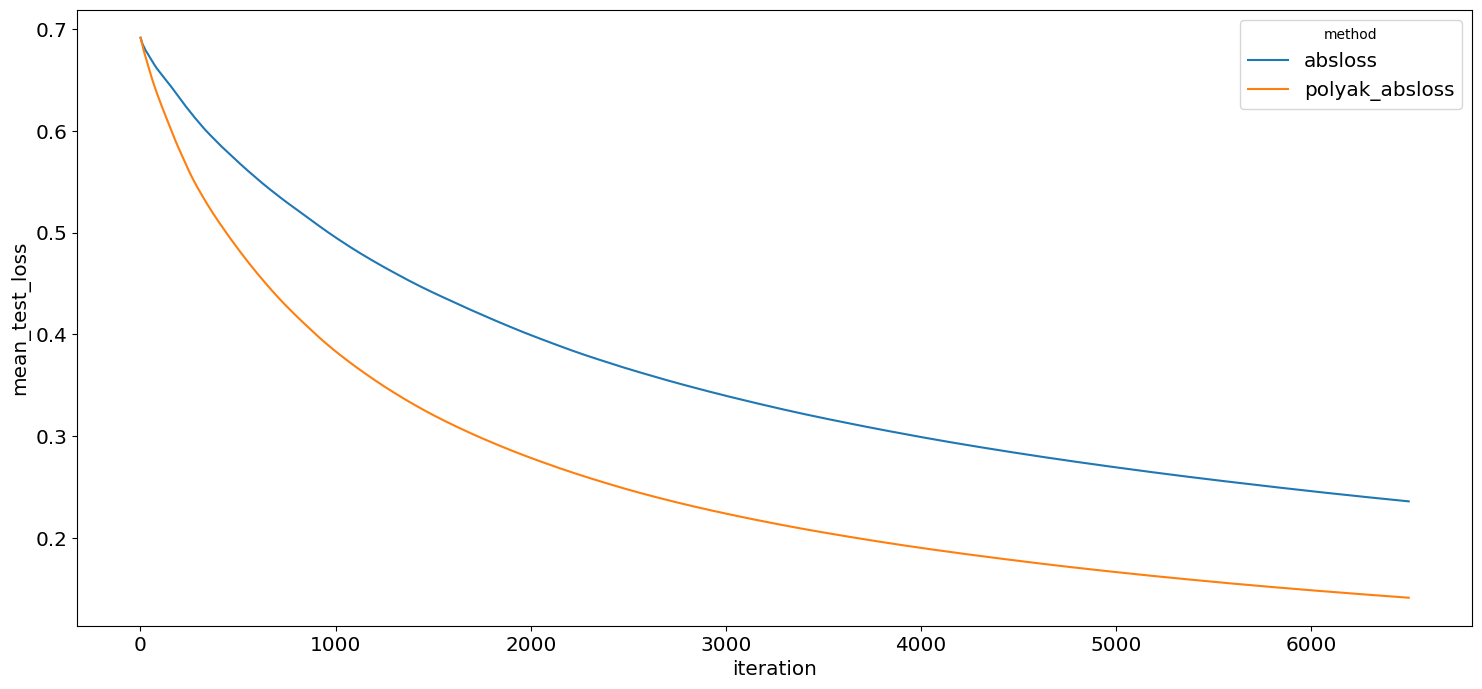

In [77]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

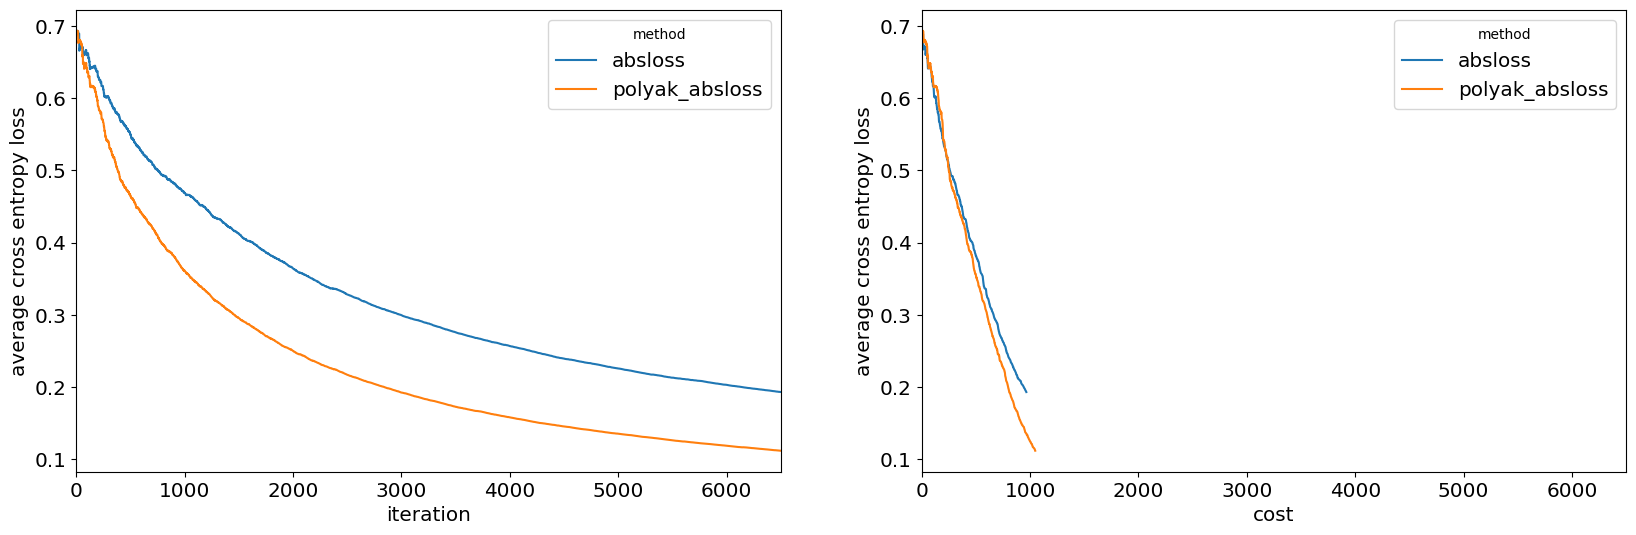

In [78]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot2_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

<Axes: xlabel='iteration', ylabel='mean_test_accuracy'>

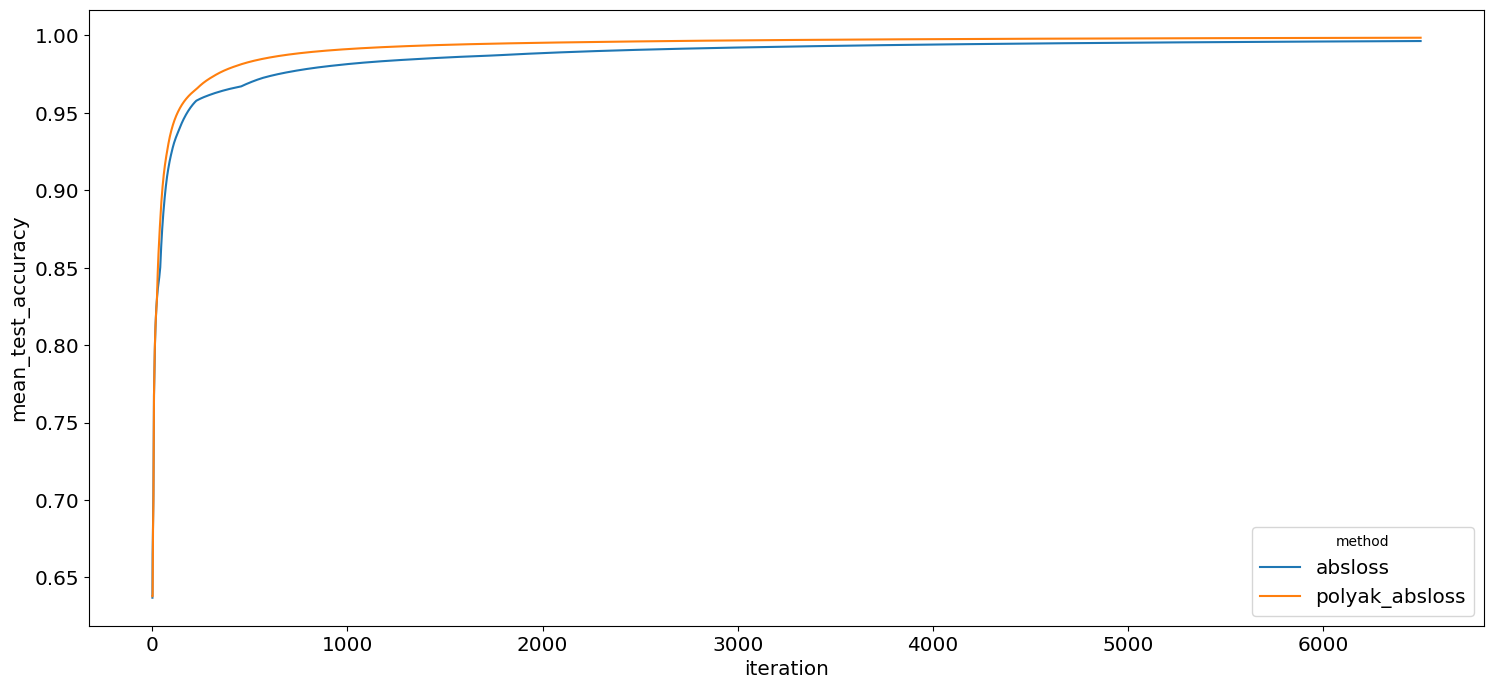

In [79]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot2_df,
    x="iteration", 
    y="mean_test_accuracy",
    hue="method"
)

In [93]:
plot02_df = results_to_df(
    {
        "random": results_rand,
        "absloss": results_absloss,
        "polyak_absloss": results_polyak_absloss,
    }
)

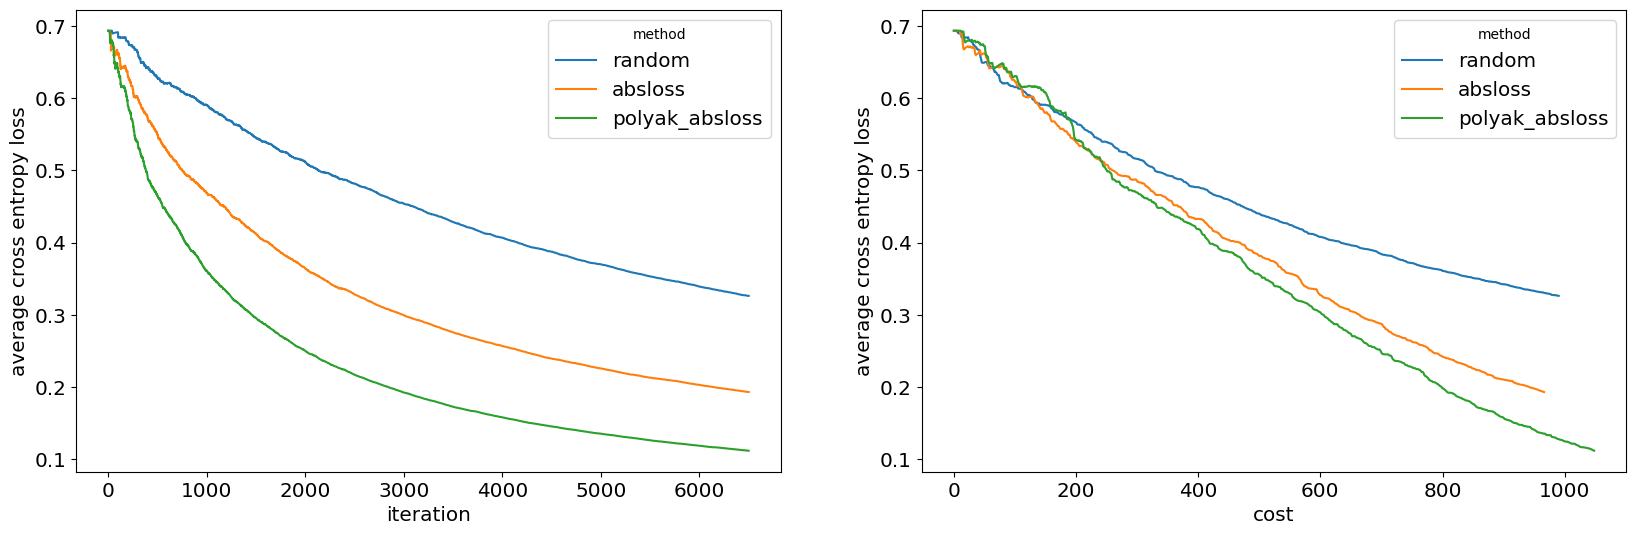

In [94]:
f, axs = plt.subplots(1, 2, figsize=(20, 6))

sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot02_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")

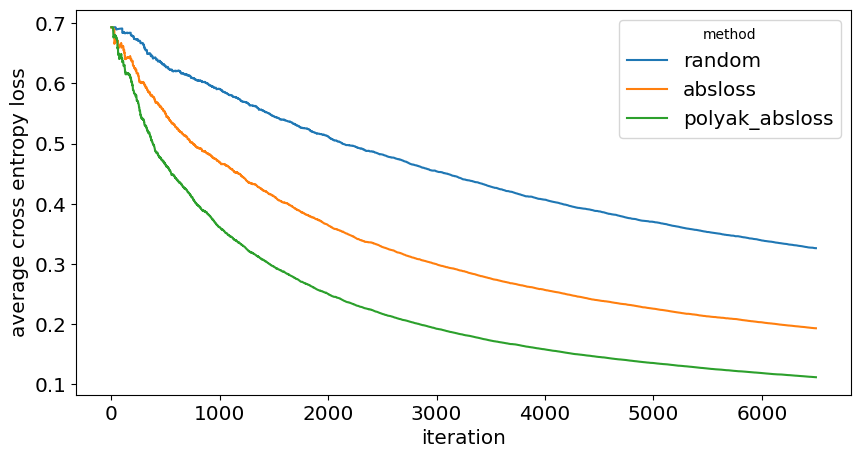

In [95]:
plt.figure(figsize=(10,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot02_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)


ax.set(ylabel="average cross entropy loss")

plt.savefig("figure_3.pdf", format="pdf", bbox_inches="tight")


# Plot 3: Include Uncertainty Sampling
First run absloss, then we run Polyak absloss with omega=1 with yields the same sampling probability



In [83]:
hyperparam_per_algo["uncertainty"]

{'eta': 300, 'omega': 0.868776567310112}

In [84]:
results_uncertainty = train_model(
    X, y, Xtest, ytest, mode="uncertainty", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["uncertainty"]
)

Training with algorithm uncertainty: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.5986287870332996, train loss: 0.5198249191990448, ||theta||_1: 12892.0636160242
loss: 0.5208670239701694, train loss: 0.6865183263939523, ||theta||_1: 24110.192628560017
loss: 0.4699953297980341, train loss: 0.593823711099132, ||theta||_1: 32667.432781462536
loss: 0.4128654984481185, train loss: 0.5523378770754429, ||theta||_1: 42611.95074997227
loss: 0.3639735030833374, train loss: 0.5211144426717712, ||theta||_1: 50567.347539127055
loss: 0.32790080105969843, train loss: 0.44572437913008545, ||theta||_1: 57998.20621847226
loss: 0.29823987763608245, train loss: 0.42986327954655124, ||theta||_1: 65083.16233127218
loss: 0.27687916060267287, train loss: 0.4216587390680321, ||theta||_1: 70651.53748357901
loss: 0.25543956373960774, train loss: 0.38889693877927106, ||theta||_1: 75910.81595352635
loss: 0.24432611333192888, train loss: 9.9978001511

In [85]:
hppa = hyperparam_per_algo["uncertainty"]
if "omega" in hppa:
    hppa["omega"] *= np.mean(results_absloss["probs"]) / np.mean(results_uncertainty["probs"])
else:
    hppa["omega"] = np.mean(results_absloss["probs"]) / np.mean(results_uncertainty["probs"])
hyperparam_per_algo["uncertainty"] = hppa
print(hppa)

{'eta': 300, 'omega': 0.8172306567885091}


In [86]:
results_uncertainty = train_model(
    X, y, Xtest, ytest, mode="uncertainty", verbose=True, 
    #**(hyperparam_per_algo["polyak_absloss"] | {"omega": 1})
    **hyperparam_per_algo["uncertainty"]
)

Training with algorithm uncertainty: 6499 iterations with d=6499
loss: 0.6931471805599452, train loss: 0.6931471805599453, ||theta||_1: 0.0
loss: 0.5960687004068563, train loss: 0.5964770365423767, ||theta||_1: 14020.528790294877
loss: 0.5291712938917176, train loss: 0.6093664835967907, ||theta||_1: 23337.790793267573
loss: 0.4666077891467581, train loss: 0.5833302924223217, ||theta||_1: 34371.27590379782
loss: 0.42259017207596905, train loss: 0.0032838398488407128, ||theta||_1: 42515.73036048064
loss: 0.3692870427026379, train loss: 0.5903637770536476, ||theta||_1: 52518.39815947756
loss: 0.33933600906325423, train loss: 0.0033143862556388793, ||theta||_1: 58971.51906744997
loss: 0.3137936146089814, train loss: 0.35653652304804784, ||theta||_1: 65196.30569574897
loss: 0.2905274831591027, train loss: 1.9170837356101735e-06, ||theta||_1: 70307.2981120064
loss: 0.2733528704570215, train loss: 0.003220477485649286, ||theta||_1: 74040.27539939097
loss: 0.2575864528218526, train loss: 0.000

In [108]:
plot_wp_df = results_to_df(
    {
        "loss-based sampling": results_absloss,
        "loss-based sampling + adaptive learning rate": results_polyak_absloss,
        "uncertainty sampling": results_uncertainty,
        "random sampling": results_rand,
    }
)

<Axes: xlabel='iteration', ylabel='mean_test_loss'>

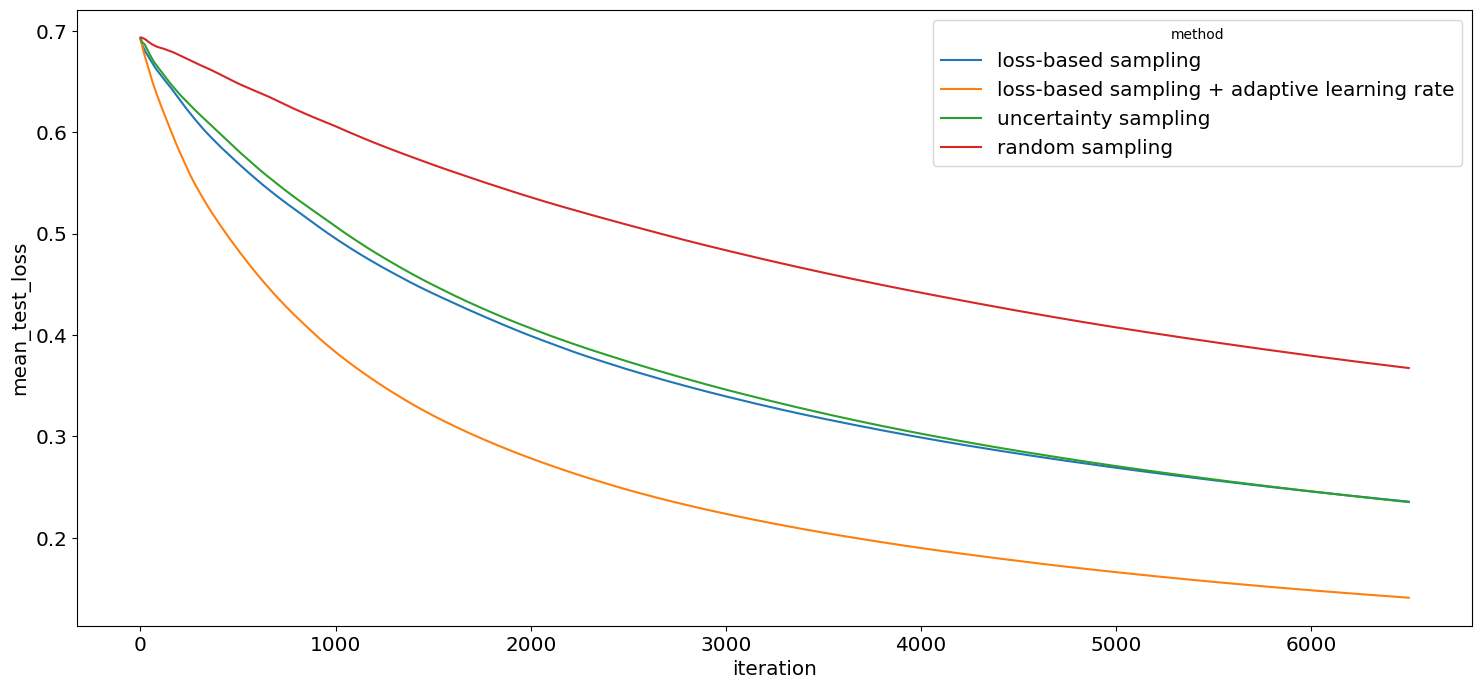

In [109]:
plt.figure(figsize=(18,8))

sns.lineplot(
    data=plot_wp_df,
    x="iteration", 
    y="mean_test_loss",
    hue="method"
)

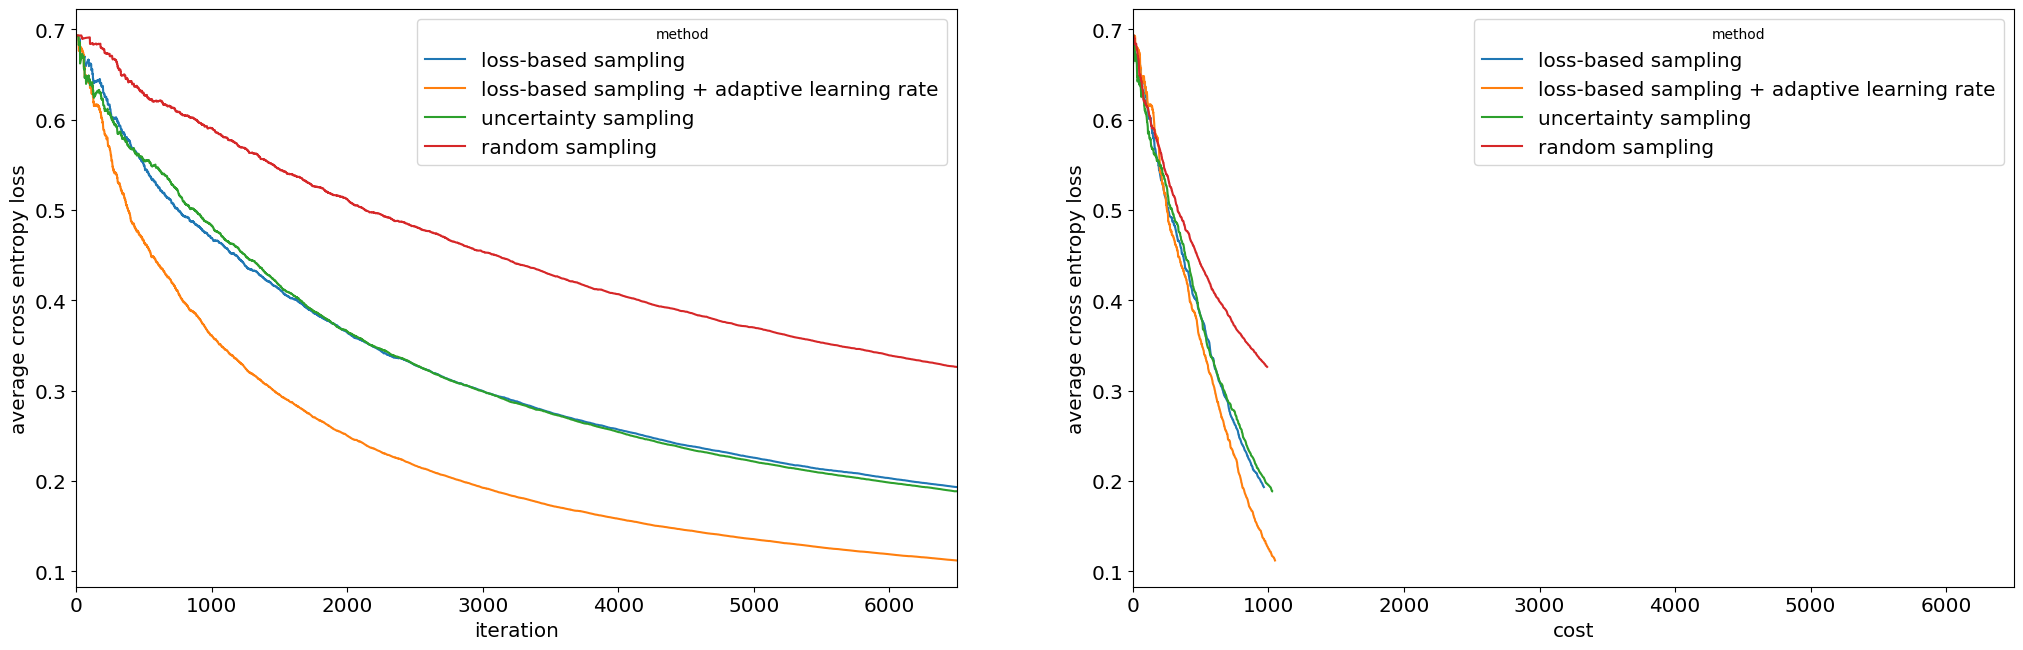

In [112]:
f, axs = plt.subplots(1, 2, figsize=(25, 7.5))

sns.lineplot(
    data=plot_wp_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method",
    ax=axs[0]
)

sns.lineplot(
    data=plot_wp_df,
    x="cost", 
    y="mean_train_loss",
    hue="method",
    ax=axs[1]
)

for i in range(2):
    axs[i].set_ylabel("average cross entropy loss")
    axs[i].set_xlim((0, 6499))

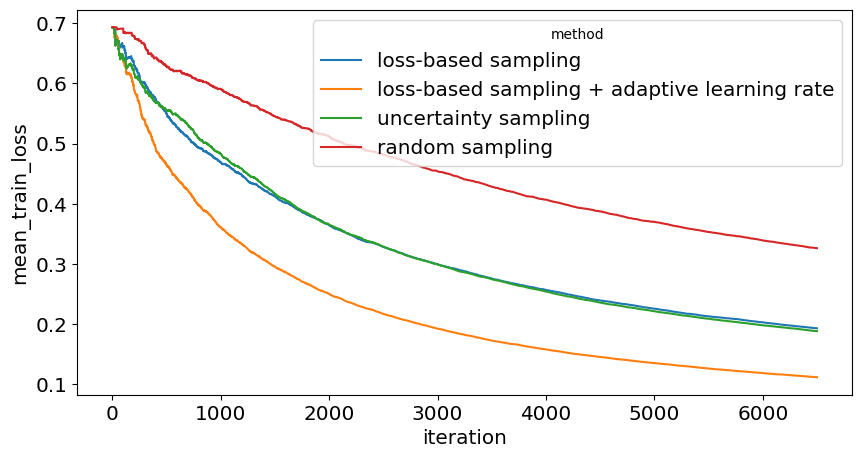

In [111]:
plt.figure(figsize=(10,5))

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

ax = sns.lineplot(
    data=plot_wp_df,
    x="iteration", 
    y="mean_train_loss",
    hue="method"
)